In [1]:
import os
import pandas as pd

data_path = 'ml-latest/'
movies_filename = 'movies.csv'
ratings_filename = 'ratings.csv'

In [2]:
#Read the data from the dataset and insert them into a dataframe see reference 8 within the report
df_movies = pd.read_csv(
    os.path.join(data_path, movies_filename),

    usecols=['movieId', 'title'],
    dtype={'movieId': 'int32', 'title': 'str'})

df_ratings = pd.read_csv(
    os.path.join(data_path, ratings_filename),
    usecols=['userId', 'movieId', 'rating'],
    dtype={'userId': 'int32', 'movieId': 'int32', 'rating': 'float32'})


In [3]:
#Show the headings of the dataframe and show the dimensions using the shape function
df_movies.head()
df_movies.shape

(58098, 2)

In [4]:
#Show headings for the rating dataset

df_ratings.head()

,userId,movieId,rating
0,1,307,3.5
1,1,481,3.5
2,1,1091,1.5
3,1,1257,4.5
4,1,1449,4.5


In [5]:
# shaping the data rating setting at 200000
df_ratings=df_ratings[:2000000]

In [6]:
df_ratings.shape


(2000000, 3)

In [7]:
from scipy.sparse import csr_matrix
#Pivot the data around the needed columns in this case the movieId, userId, and Rating see reference 8 within the report
df_movie_features = df_ratings.pivot(
    index='movieId',
    columns='userId',
    values='rating'
).fillna(0)

In [8]:
mat_movie_features = csr_matrix(df_movie_features.values)

In [9]:
df_movie_features.head()

userId,1,2,3,4,5,6,7,8,9,10,...,20498,20499,20500,20501,20502,20503,20504,20505,20506,20507
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,5.0,...,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,5.0
2,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,2.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,4.5,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
from sklearn.neighbors import NearestNeighbors
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)

In [11]:

# Count for 0 rating has too big a range to compare with other ratings, create a log to transform count values to then plot and compare see reference 8 within the report
num_users = len(df_ratings.userId.unique())
num_items = len(df_ratings.movieId.unique())
print('There are {} unique users and {} unique movies in this data set'.format(num_users, num_items))

There are 20507 unique users and 26030 unique movies in this data set


In [12]:
# getting the count
df_ratings_cnt_tmp = pd.DataFrame(df_ratings.groupby('rating').size(), columns=['count'])
df_ratings_cnt_tmp


,count
rating,
0.5,37006
1.0,63892
1.5,31587
2.0,134360
2.5,96299
3.0,399042
3.5,240378
4.0,531498
4.5,169475


In [13]:
# getting all counts within 0 see reference 8 and 6 within report
total_cnt = num_users * num_items
rating_zero_cnt = total_cnt - df_ratings.shape[0]

df_ratings_cnt = df_ratings_cnt_tmp.append(
    pd.DataFrame({'count': rating_zero_cnt}, index=[0.0]),
    verify_integrity=True,
).sort_index()
df_ratings_cnt

,count
0.0,531797210
0.5,37006
1.0,63892
1.5,31587
2.0,134360
2.5,96299
3.0,399042
3.5,240378
4.0,531498
4.5,169475


In [14]:
#normalise log to visualise easier see reference 1 and 8 in report
import numpy as np
df_ratings_cnt['log_count'] = np.log(df_ratings_cnt['count'])
df_ratings_cnt

,count,log_count
0.0,531797210,20.091773
0.5,37006,10.518835
1.0,63892,11.064949
1.5,31587,10.360501
2.0,134360,11.808278
2.5,96299,11.475213
3.0,399042,12.896822
3.5,240378,12.389968
4.0,531498,13.183455
4.5,169475,12.040461


Text(0, 0.5, 'number of ratings')

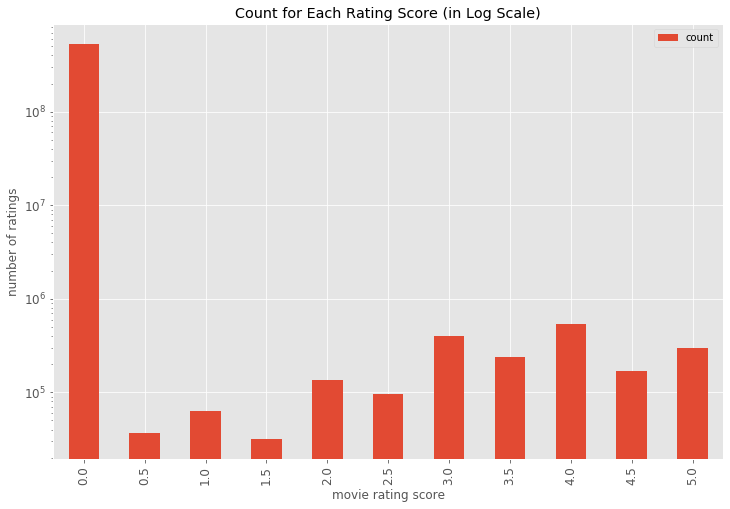

In [15]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

get_ipython().run_line_magic('matplotlib', 'inline')
ax = df_ratings_cnt[['count']].reset_index().rename(columns={'index': 'rating score'}).plot(
    x='rating score',
    y='count',
    kind='bar',
    figsize=(12, 8),
    title='Count for Each Rating Score (in Log Scale)',
    logy=True,
    fontsize=12,
)
ax.set_xlabel("movie rating score")
ax.set_ylabel("number of ratings")

In [16]:
#get the ratings and number of ratings for each movie 
df_movies_cnt = pd.DataFrame(df_ratings.groupby('movieId').size(), columns=['count'])
df_movies_cnt.head()

,count
movieId,
1,4923
2,1975
3,1188
4,242
5,1138


In [17]:
#include movies with a threshold of 50 check reference 8, 7 and 5 in the report

popularity_thres = 50
popular_movies = list(set(df_movies_cnt.query('count >= @popularity_thres').index))
df_ratings_drop_movies = df_ratings[df_ratings.movieId.isin(popular_movies)]
print('shape of original ratings data: ', df_ratings.shape)
print('shape of ratings data after dropping unpopular movies: ', df_ratings_drop_movies.shape)

shape of original ratings data:  (2000000, 3)
shape of ratings data after dropping unpopular movies:  (1847158, 3)


In [18]:
# get the ratings from users
df_users_cnt = pd.DataFrame(df_ratings_drop_movies.groupby('userId').size(), columns=['count'])
df_users_cnt.head()

,count
userId,
1,16
2,15
3,8
4,714
5,71


In [19]:
# filter data to get users tasts, check reference 5
ratings_thres = 50
active_users = list(set(df_users_cnt.query('count >= @ratings_thres').index))
df_ratings_drop_users = df_ratings_drop_movies[df_ratings_drop_movies.userId.isin(active_users)]
print('shape of original ratings data: ', df_ratings.shape)
print('shape of ratings data after dropping both unpopular movies and inactive users: ', df_ratings_drop_users.shape)

shape of original ratings data:  (2000000, 3)
shape of ratings data after dropping both unpopular movies and inactive users:  (1611936, 3)


In [20]:
# create movie matrix, see reference 8 in report
movie_user_mat = df_ratings_drop_users.pivot(index='movieId', columns='userId', values='rating').fillna(0)
#map movie titles to images
movie_to_idx = {
    movie: i for i, movie in 
    enumerate(list(df_movies.set_index('movieId').loc[movie_user_mat.index].title))
}
# transform the matrix into a scipy, see reference 9 in the report 
movie_user_mat_sparse = csr_matrix(movie_user_mat.values)

In [21]:
movie_user_mat_sparse

<4802x7757 sparse matrix of type '<class 'numpy.float32'>'
	with 1611936 stored elements in Compressed Sparse Row format>

In [22]:
# define model see reference 7, 6 and 9 in the report
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
# fit
model_knn.fit(movie_user_mat_sparse)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=-1, n_neighbors=20, p=2,
                 radius=1.0)

In [23]:
from fuzzywuzzy import fuzz

E:\InstalledSoftware\Anaconda\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [24]:
#method for matching similar search terms to possible data in dataframe, see reference 8 for this 
def fuzzy_matching(mapper, fav_movie, verbose=True):
    """
    return the closest match via fuzzy ratio. 
    
    Parameters
    ----------    
    mapper: dict, map movie title name to index of the movie in data

    fav_movie: str, name of user input movie
    
    verbose: bool, print log if True

    Return
    ------
    index of the closest match
    """
    match_tuple = []
    # get fuzzy match for the search term
    for title, idx in mapper.items():
        ratio = fuzz.ratio(title.lower(), fav_movie.lower())
        if ratio >= 60:
            match_tuple.append((title, idx, ratio))
    # sort tuple in order of priority
    match_tuple = sorted(match_tuple, key=lambda x: x[2])[::-1]
    if not match_tuple:
        print('There are no matches found for your search term')
        return
    if verbose:
        print('Found possible matches in our database: {0}\n'.format([x[0] for x in match_tuple]))
    return match_tuple[0][1]

In [25]:
#method for recommending movies based on the KNN model, see reference 7 and 8 within the report
def make_recommendation(model_knn, data, mapper, fav_movie, n_recommendations):
    """
    return top n similar movie recommendations based on user's input movie


    Parameters
    ----------
    model_knn: sklearn model, knn model

    data: movie-user matrix

    mapper: dict, map movie title name to index of the movie in data

    fav_movie: str, name of user input movie

    n_recommendations: int, top n recommendations

    Return
    ------
    list of top n similar movie recommendations
    """
    # fit
    model_knn.fit(data)
    # get input movie index
    print('You have input movie:', fav_movie)
    idx = fuzzy_matching(mapper, fav_movie, verbose=True)
    
    print('Recommendation system start to make inference')
    print('......\n')
    distances, indices = model_knn.kneighbors(data[idx], n_neighbors=n_recommendations+1)
    
    raw_recommends =         sorted(list(zip(indices.squeeze().tolist(), distances.squeeze().tolist())), key=lambda x: x[1])[:0:-1]
    # get reverse mapper
    reverse_mapper = {v: k for k, v in mapper.items()}
    # print recommendations
    print('Recommendations for {}:'.format(fav_movie))
    for i, (idx, dist) in enumerate(raw_recommends):
        print('{0}: {1}, with distance of {2}'.format(i+1, reverse_mapper[idx], dist))

In [26]:
user_input = input('Please enter a movie')

make_recommendation(
    model_knn=model_knn,
    data=movie_user_mat_sparse,
    fav_movie=user_input,
    mapper=movie_to_idx,
    n_recommendations=10)

Please enter a movieSpider Man
You have input movie: Spider Man
Found possible matches in our database: ['Spider-Man (2002)', 'Spider-Man 3 (2007)', 'Spider-Man 2 (2004)', 'Spider (2002)']

Recommendation system start to make inference
......

Recommendations for Spider Man:
1: Lord of the Rings: The Return of the King, The (2003), with distance of 0.3985353708267212
2: Ocean's Eleven (2001), with distance of 0.389157772064209
3: Minority Report (2002), with distance of 0.38623547554016113
4: Lord of the Rings: The Two Towers, The (2002), with distance of 0.3744795322418213
5: Shrek (2001), with distance of 0.37224310636520386
6: Pirates of the Caribbean: The Curse of the Black Pearl (2003), with distance of 0.37194472551345825
7: X2: X-Men United (2003), with distance of 0.37088292837142944
8: Lord of the Rings: The Fellowship of the Ring, The (2001), with distance of 0.3658738136291504
9: X-Men (2000), with distance of 0.3391755223274231
10: Spider-Man 2 (2004), with distance of 0.28